# Capstone Final Project - Analyze Indian Resturants in Tornoto

### Importing required Python Libraries including BeautifulSoup to deal with wikipedia data

In [2]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup
import os

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# Use SHIFT+TAB keys to popup inplace code help
%config IPCompleter.greedy = True

# Output multiple statements from one input cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Essential Libraries importing DONE.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### Loading the data from Wikipedia page and parse the table data

In [3]:
table_from_top = 1
wikipedia_page = 'List_of_postal_codes_of_Canada:_M'
trace = False

wikipedia_url = 'https://en.wikipedia.org/wiki/{}'.format(wikipedia_page)
page = requests.get(wikipedia_url)
soup = BeautifulSoup(page.content, 'lxml')
tables = soup.find_all('table', {'class': 'wikitable'})
table = tables[table_from_top - 1]

### Extract the table header with column names.

In [4]:
feature_names = []

header_row = table.find('tr')
for header in header_row.find_all('th'):
    feature_name = ' '.join(header.find_all(text=True))
    feature_name.replace('\n', '')
    feature_names.append(feature_name)

'Postcode'

'Borough'

'Neighbourhood'

### Data Wrangling - This section applies data wrangling rules based on exceptions found when parsing Wikipedia tables.

In [5]:

samples = []
sample_rows = table.find_all('tr')[1:]
for sample_row in sample_rows:
    features = []
    for feature_col in sample_row.find_all('td'):
        feature_value = ''
        text = feature_col.string

        if text:
            features.append(text)
            continue
        
        for child in feature_col.children:         
            feature_value = child.string
            break

        features.append(feature_value)
    
    #Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.   
    if features[1] == "Not assigned":
        continue
    else:
        samples.append(dict(zip(feature_names, features)))

### Applying additional rules as per the project requirement 

In [6]:
df = pd.DataFrame(samples)
df = df.replace('\n','', regex=True)

# Rename columns to match: The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
df.rename(columns={'Postcode': 'PostalCode', 'Neighbourhood\n': 'Neighborhood'}, inplace=True)

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
df['Neighborhood'] = np.where(df['Neighborhood']=="Not assigned", df['Borough'], df['Neighborhood'])

# Group and Concatenate "neighborhood" values 
df_group = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(','.join).reset_index()
df_group

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [7]:
df_group.shape

(103, 3)

### Get the latitude and the longitude coordinates of each neighborhood
### Read and Load the Data from the csv file into Dataframe that has geographical coordinates of each postal code: 

In [8]:
df2 = pd.read_csv('http://cocl.us/Geospatial_data')
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge the Two Dataframes to include all the columns in one Dataframe for the matching field PostalCode

In [9]:
#result = pd.concat([df_group, df2], axis=1, sort=False)
result = pd.merge(left=df_group,right=df2, how='left', left_on='PostalCode', right_on='Postal Code')
neighborhoods_data = result.drop(['Postal Code'], axis=1)
neighborhoods_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


### Create new Dataframe with subset of Data containing toronto for which we will explore

In [10]:
toronto_data = neighborhoods_data[neighborhoods_data['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.drop("PostalCode", axis=1, inplace=True)

toronto_data

,Borough,Neighborhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790
5,Central Toronto,Davisville North,43.712751,-79.390197
6,Central Toronto,North Toronto West,43.715383,-79.405678
7,Central Toronto,Davisville,43.704324,-79.388790
8,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
9,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


In [11]:
toronto_data.shape

(39, 4)

### We Got 39 different neighbourhoods in Toronto

<Figure size 800x400 with 0 Axes>

Text(0.5, 1.0, 'Number of Neighborhood for each Borough in Toronto')

Text(0.5, 0, 'Borough')

Text(0, 0.5, 'No.of Neighborhood')

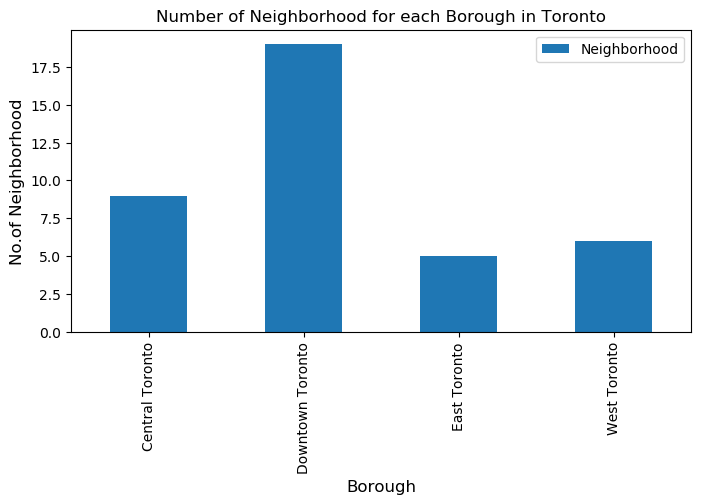

In [12]:
plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
toronto_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Observations: 

The Borough Downtown Toronto is having highest number of neighborhoods in Toronto

### Defining the Functions required to get Location and Venue Details

In [13]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="tornoto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [29]:
def get_venues(lat,lng):
    
    #set variables
    radius=5000
    LIMIT=1000


    CLIENT_ID = "ZPUIMBXLBWT011DSFPDA4Z5SJH4EQJDZZDZMMMJ3PLEJDESG"
    CLIENT_SECRET = "3BOEWRIN2I52GTD5Y5IDE0E4CIU0ILGNPXGJRULM5QVXZ5TQ"
    VERSION = 20190101
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [30]:
def get_venue_details(venue_id):
        
    
    CLIENT_ID = "ZPUIMBXLBWT011DSFPDA4Z5SJH4EQJDZZDZMMMJ3PLEJDESG"
    CLIENT_SECRET = "3BOEWRIN2I52GTD5Y5IDE0E4CIU0ILGNPXGJRULM5QVXZ5TQ"
    
    VERSION = 20190101
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
   # print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Data collection: Lets collect "Indian Restaurant" for each Neighborhood

In [18]:
# prepare neighborhood list that contains Health Food Store
column_names=['Borough', 'Neighborhood', 'ID','Name']
hfs_toronto=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    hf_stores=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(toronto_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(hf_stores)))
    for hfs in hf_stores.values.tolist():
        id, name , category=hfs
        hfs_toronto = hfs_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 39 ) Indian Resturants in The Beaches, East Toronto:3
( 2 / 39 ) Indian Resturants in The Danforth West,Riverdale, East Toronto:1
( 3 / 39 ) Indian Resturants in The Beaches West,India Bazaar, East Toronto:2
( 4 / 39 ) Indian Resturants in Studio District, East Toronto:1
( 5 / 39 ) Indian Resturants in Lawrence Park, Central Toronto:1
( 6 / 39 ) Indian Resturants in Davisville North, Central Toronto:2
( 7 / 39 ) Indian Resturants in North Toronto West, Central Toronto:2
( 8 / 39 ) Indian Resturants in Davisville, Central Toronto:3
( 9 / 39 ) Indian Resturants in Moore Park,Summerhill East, Central Toronto:2
( 10 / 39 ) Indian Resturants in Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West, Central Toronto:3
( 11 / 39 ) Indian Resturants in Rosedale, Downtown Toronto:1
( 12 / 39 ) Indian Resturants in Cabbagetown,St. James Town, Downtown Toronto:0
( 13 / 39 ) Indian Resturants in Church and Wellesley, Downtown Toronto:1
( 14 / 39 ) Indian Resturants in Harbourfront, Do

### Get the geographical coordinates of Toronto

<Figure size 900x500 with 0 Axes>

Text(0.5, 1.0, 'Number of Indian Resturants for each Borough in Toronto')

Text(0.5, 0, 'Borough')

Text(0, 0.5, 'No.of Indian Resturants')

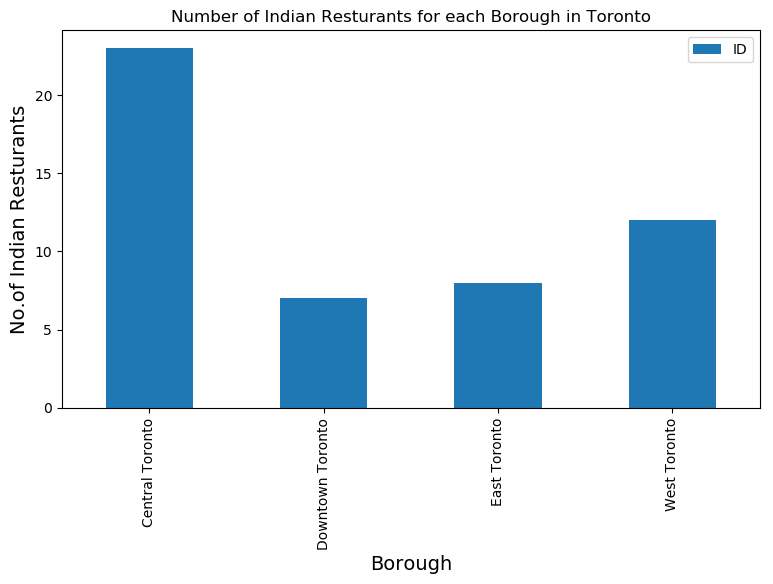

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=14)
#giving a bar plot
hfs_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<Figure size 900x500 with 0 Axes>

Text(0.5, 1.0, 'Number of Indian Restaurants for each Neighborhood in Toronto')

Text(0.5, 0, 'Neighborhood')

Text(0, 0.5, 'No.of Indian Restaurants')

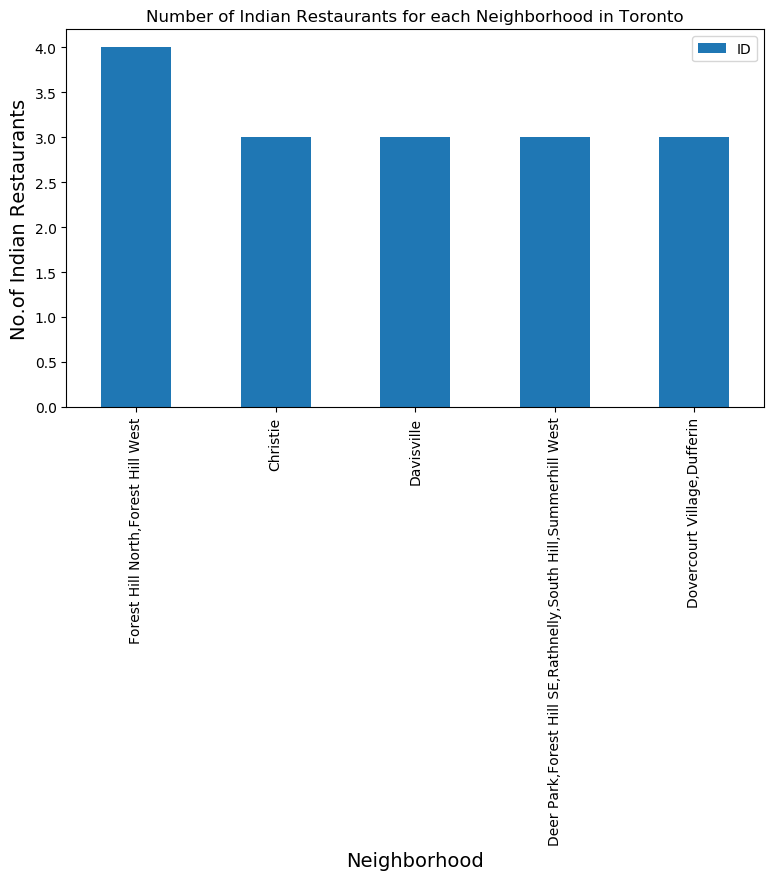

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 14)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=14)
#giving a bar plot
hfs_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we will get the ranking of each Indian Restaurant for further analysis

In [32]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
hfs_stats_toronto=pd.DataFrame(columns=column_names)
count=1

for row in hfs_toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(hfs_toronto),')','processed')
    hfs_stats_toronto = hfs_stats_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)

KeyError: 'venue'

Exporting the dataset to csv file.

In [22]:
hfs_stats_toronto.to_csv('Indian_Restaurant_Tornoto.csv', index=False)

In [23]:
#Reading th file
hfs_stats_toronto=pd.read_csv('Indian_Restaurant_Tornoto.csv')

In [24]:
hfs_stats_toronto

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,East Toronto,The Beaches,4ae0c7a8f964a520638221e3,Udupi Palace,79,8.6,31
1,East Toronto,The Beaches,4afc9816f964a520312422e3,Motimahal,25,7.8,13
2,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,7.1,3
3,East Toronto,"The Danforth West,Riverdale",4ae0c7a8f964a520638221e3,Udupi Palace,79,8.6,31
4,East Toronto,"The Beaches West,India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace,79,8.6,31
5,East Toronto,"The Beaches West,India Bazaar",4afc9816f964a520312422e3,Motimahal,25,7.8,13
6,East Toronto,Studio District,4ae0c7a8f964a520638221e3,Udupi Palace,79,8.6,31
7,Central Toronto,Lawrence Park,4b75c28af964a520ba222ee3,Kamasutra,18,8.2,12
8,Central Toronto,Davisville North,4daf08e66e81e2dffdd4fe40,Iqbal Kebab & Sweet Centre,13,8.0,6
9,Central Toronto,Davisville North,4c62c59ce1621b8dd0332453,Roti Cuisine of India,39,8.8,18


In [25]:
hfs_stats_toronto.shape

(50, 7)

In [26]:
hfs_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null int64
Rating          50 non-null float64
Tips            50 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.8+ KB


Lets start analyzing the Data

In [49]:
# Indian Restaurant with maximum Likes
hfs_stats_toronto.iloc[hfs_stats_toronto['Likes'].idxmax()]

Borough                                           Central Toronto
Neighborhood    Deer Park,Forest Hill SE,Rathnelly,South Hill,...
ID                                       4adb969ef964a520332921e3
Name                                       Banjara Indian Cuisine
Likes                                                         142
Rating                                                        8.9
Tips                                                           75
Name: 19, dtype: object

In [51]:
# Indian Restaurant with maximum Rating
hfs_stats_toronto.iloc[hfs_stats_toronto['Rating'].idxmax()]

Borough                  Central Toronto
Neighborhood          North Toronto West
ID              52418b0b7e48222eea81d2d2
Name                    Pukka Restaurant
Likes                                 43
Rating                               9.1
Tips                                  26
Name: 11, dtype: object

In [52]:
# Indian Restaurant with maximum Tips
hfs_stats_toronto.iloc[hfs_stats_toronto['Tips'].idxmax()]

Borough                                           Central Toronto
Neighborhood    Deer Park,Forest Hill SE,Rathnelly,South Hill,...
ID                                       4adb969ef964a520332921e3
Name                                       Banjara Indian Cuisine
Likes                                                         142
Rating                                                        8.9
Tips                                                           75
Name: 19, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [53]:
toronto_neighborhood_stats=hfs_stats_toronto.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [54]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,"Moore Park,Summerhill East",8.950000
20,"The Annex,North Midtown,Yorkville",8.933333
2,Christie,8.933333
7,"Dovercourt Village,Dufferin",8.933333
6,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",8.933333
0,"Brockton,Exhibition Place,Parkdale Village",8.900000
12,"Little Portugal,Trinity",8.900000
9,"Harbord,University of Toronto",8.850000
16,Rosedale,8.800000
3,Church and Wellesley,8.800000


Above are the top neighborhoods with top average rating of Indian Restaurants

In [55]:
toronto_borough_stats=hfs_stats_toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

Similarly these are the average rating of Indian Restaurant for each Borough

In [56]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Downtown Toronto,8.871429
3,West Toronto,8.758333
0,Central Toronto,8.691304
2,East Toronto,8.212500


Data Visualization

<Figure size 900x500 with 0 Axes>

Text(0.5, 1.0, 'Average rating of Indian Restaurant for each Borough')

Text(0.5, 0, 'Borough')

Text(0, 0.5, 'Average Rating')

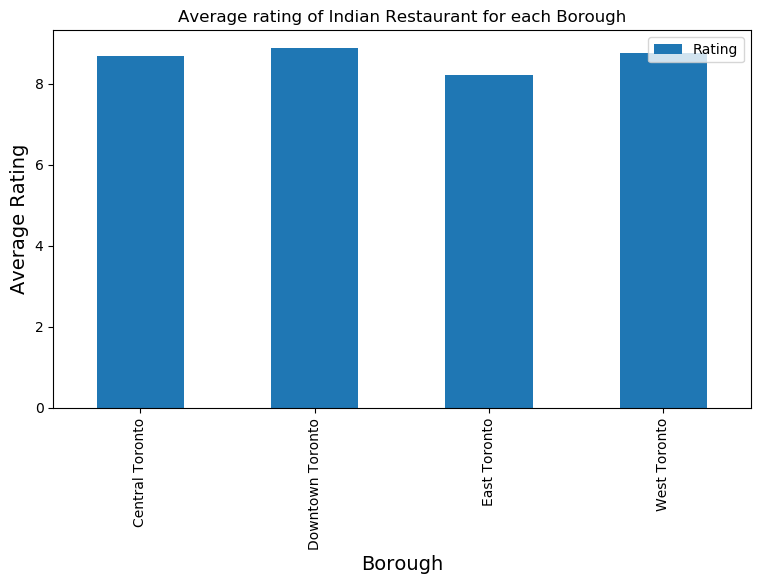

In [57]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('Average Rating', fontsize=14)
#giving a bar plot
hfs_stats_toronto.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater than 8.5 to visualize on map

In [58]:
toronoto_neighborhood_stats=toronto_neighborhood_stats[toronto_neighborhood_stats['Average Rating']>8.5]

In [59]:
toronoto_neighborhood_stats

,Neighborhood,Average Rating
0,"Brockton,Exhibition Place,Parkdale Village",8.900000
1,Business Reply Mail Processing Centre 969 Eastern,8.600000
2,Christie,8.933333
3,Church and Wellesley,8.800000
6,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",8.933333
7,"Dovercourt Village,Dufferin",8.933333
8,"Forest Hill North,Forest Hill West",8.750000
9,"Harbord,University of Toronto",8.850000
10,"High Park,The Junction South",8.800000
12,"Little Portugal,Trinity",8.900000


We will join this dataset to original Tornoto data to get lonitude and latitude

In [60]:
toronto_neighborhood_stats=pd.merge(toronto_neighborhood_stats,toronto_data, on='Neighborhood')

In [61]:
toronto_neighborhood_stats=toronto_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [62]:
toronto_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,8.900000
1,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,8.600000
2,Downtown Toronto,Christie,43.669542,-79.422564,8.933333
3,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.800000
4,Central Toronto,Davisville,43.704324,-79.388790,8.333333
5,Central Toronto,Davisville North,43.712751,-79.390197,8.400000
6,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,8.933333
7,West Toronto,"Dovercourt Village,Dufferin",43.669005,-79.442259,8.933333
8,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307,8.750000
9,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,8.850000


Now we will plot this data on a map

In [63]:
# create map and display it
toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [64]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in toronto_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [65]:
toronto_neighborhood_stats['Label']=toronto_neighborhood_stats['Neighborhood']+', '+toronto_neighborhood_stats['Borough']+'('+toronto_neighborhood_stats['Average Rating'].map(str)+')'

In [66]:
toronto_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,8.900000,"Brockton,Exhibition Place,Parkdale Village, We..."
1,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,8.600000,Business Reply Mail Processing Centre 969 East...
2,Downtown Toronto,Christie,43.669542,-79.422564,8.933333,"Christie, Downtown Toronto(8.933333333333334)"
3,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.800000,"Church and Wellesley, Downtown Toronto(8.8)"
4,Central Toronto,Davisville,43.704324,-79.388790,8.333333,"Davisville, Central Toronto(8.333333333333334)"
5,Central Toronto,Davisville North,43.712751,-79.390197,8.400000,"Davisville North, Central Toronto(8.4)"
6,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,8.933333,"Deer Park,Forest Hill SE,Rathnelly,South Hill,..."
7,West Toronto,"Dovercourt Village,Dufferin",43.669005,-79.442259,8.933333,"Dovercourt Village,Dufferin, West Toronto(8.93..."
8,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307,8.750000,"Forest Hill North,Forest Hill West, Central To..."
9,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,8.850000,"Harbord,University of Toronto, Downtown Toront..."


Visualize the Neighborhoods.

In [1]:
# add pop-up text to each marker on the map
for lat, lng, label in toronto_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)        
# add incidents to map
toronto_map.add_child(incidents)

NameError: name 'toronto_neighborhood_stats' is not defined